# Parse Sun-Photometer V 1.1 during 19th May

Here I check that the radiometric calibration works even for clouds during 19 May.

In [1]:
from __future__ import division
%matplotlib inline
import CameraNetwork
from CameraNetwork.sunphotometer import calcAlmucantarPrinciplePlanes
from CameraNetwork.sunphotometer import findClosestImageTime
from CameraNetwork.sunphotometer import integrate_QE_SP
from CameraNetwork.sunphotometer import parseSunPhotoMeter
from CameraNetwork.sunphotometer import readSunPhotoMeter
from CameraNetwork.sunphotometer import sampleData, sampleImage
import cPickle
import cv2
import datetime
from dateutil import parser
import ephem
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 8.0)
import numpy as np
import os
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline
from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm_notebook, trange, tqdm
idx = pd.IndexSlice

/home/amitibo/code/cameranetwork/CameraNetwork/transformation_matrices.py:1899: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


## Parse the sunphotometer data

In [2]:
SUNPHOTOMETER_WAVELENGTHS = (0.4405, 0.5000, 0.6744)
df = parseSunPhotoMeter(r'../../../data/aeronet/2017_05/170501_170531_Technion_Haifa_IL.alm')
date = '2017-05-19'
spm_dfs = [df[date][df[date]["Wavelength(um)"]==wl] for wl in SUNPHOTOMETER_WAVELENGTHS]

In [3]:
spm_dfs[2]

,Wavelength(um),SolarZenithAngle(degrees),0.000000,-6.000000,-5.000000,-4.000000,-3.500000,-3.000000,-2.500000,-2.000000,...,-3.000000.1,-2.500000.1,-2.000000.1,2.000000.1,2.500000.1,3.000000.1,3.500000.1,4.000000.1,5.000000.1,6.000000.2
Date(dd-mm-yyyy)_Time(hh:mm:ss),,,,,,,,,,,,,,,,,,,,,
2017-05-19 04:02:05,0.6744,74.166396,-100,162.540115,207.491537,278.036628,329.447404,399.179998,-100.0,-100.0,...,399.179998,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2017-05-19 04:26:27,0.6744,69.173207,-100,164.262648,213.647077,290.049726,346.178553,422.845290,-100.0,-100.0,...,422.845290,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2017-05-19 12:42:06,0.6744,43.176761,-100,68.449616,86.070108,111.657420,131.879322,159.519309,-100.0,-100.0,...,159.519309,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2017-05-19 14:07:31,0.6744,61.079927,-100,60.733068,76.825604,101.777162,120.267323,145.401751,-100.0,-100.0,...,145.401751,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0


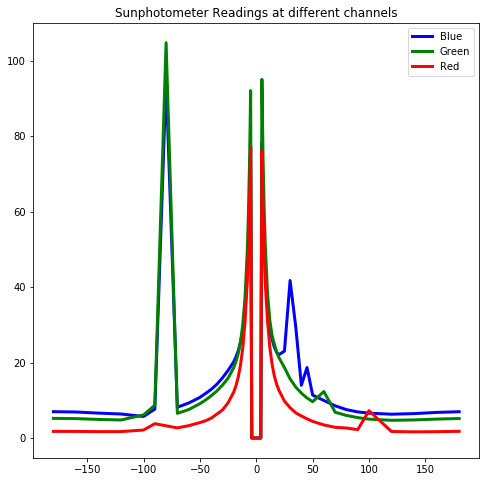

In [4]:
angles_blue, values_blue = readSunPhotoMeter(spm_dfs[0], spm_dfs[0].index[-1])
angles_green, values_green = readSunPhotoMeter(spm_dfs[1], spm_dfs[1].index[-1])
angles_red, values_red = readSunPhotoMeter(spm_dfs[2], spm_dfs[2].index[-1])
plt.plot(angles_blue, values_blue, "b", linewidth=3, label="Blue")
plt.plot(angles_green, values_green, "g", linewidth=3, label="Green")
plt.plot(angles_red, values_red, "r", linewidth=3, label="Red")
plt.title("Sunphotometer Readings at different channels")
plt.legend()

## Read the Quantom Efficiencies Files

In [5]:
base_path = r"../../../data/camera_QE"
QEs = [
    pd.read_csv(os.path.join(base_path, "UI-1551LE-C_QE-red auto.csv"), names=["wavelength", "QE"]),
    pd.read_csv(os.path.join(base_path, "UI-1551LE-C_QE-green auto.csv"), names=["wavelength", "QE"]),
    pd.read_csv(os.path.join(base_path, "UI-1551LE-C_QE-blue auto.csv"), names=["wavelength", "QE"]),
]

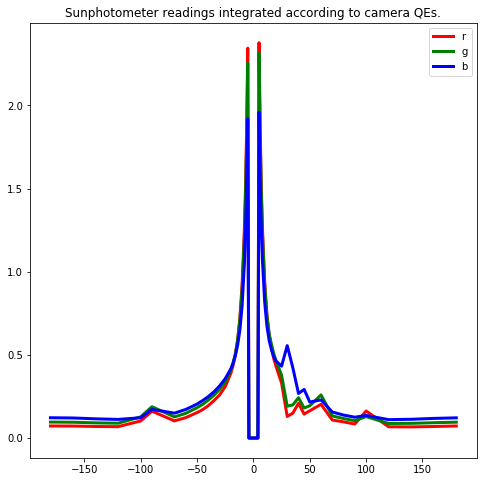

In [6]:
blue_df = pd.DataFrame(data={SUNPHOTOMETER_WAVELENGTHS[0]: values_blue}, index=angles_blue)
green_df = pd.DataFrame(data={SUNPHOTOMETER_WAVELENGTHS[1]: values_green}, index=angles_green)
red_df = pd.DataFrame(data={SUNPHOTOMETER_WAVELENGTHS[2]: values_red}, index=angles_red)
SPM_df = pd.concat((blue_df, green_df, red_df), axis=1).dropna()

for ch_index, color in enumerate(("r", "g", "b")):
    angles, values = integrate_QE_SP(SPM_df, QEs[ch_index])
    plt.plot(angles, values, color, linewidth=3, label=color)
    
plt.title("Sunphotometer readings integrated according to camera QEs.")
plt.legend()

## Connect to the cameras offline

In [7]:
camera_client = CameraNetwork.CLIclient()
proxy_params = CameraNetwork.retrieve_proxy_parameters()
camera_client.start(proxy_params)

In [9]:
camera_client.servers_list

['117',
 '219',
 'cam_109L',
 'cam_109bL',
 'cam_109cL',
 'cam_110L',
 'cam_110bL',
 'cam_111L',
 'cam_111bL',
 'cam_111cL',
 'cam_112L',
 'cam_112bL',
 'cam_113L',
 'cam_114L',
 'cam_114bL',
 'cam_114cL',
 'cam_115L',
 'cam_115bL',
 'cam_116L',
 'cam_116bL',
 'cam_116cL',
 'cam_117L',
 'cam_118L',
 'cam_118bL',
 'cam_119L',
 'cam_119bL',
 'cam_120L']

## Fit a model to specific time

### Visualize one time.

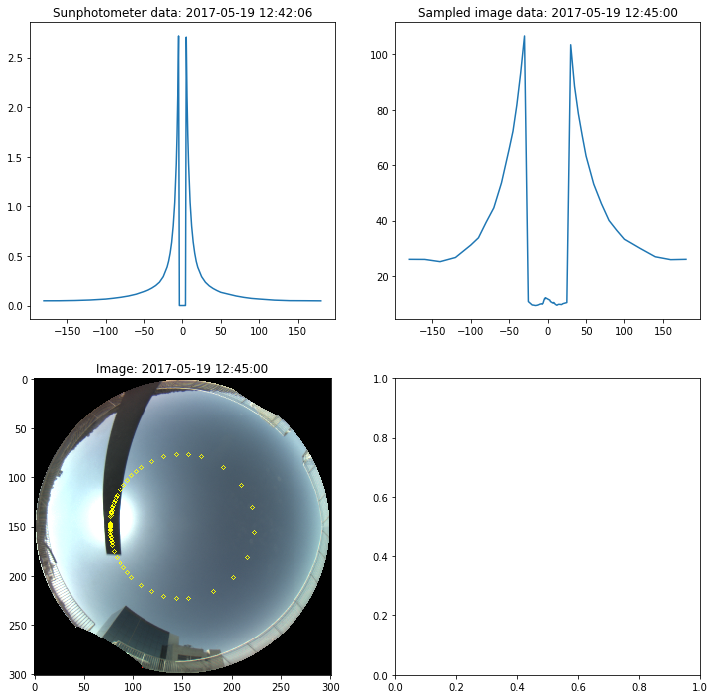

In [59]:
camera_id = 'cam_112bL'
time_index = -2
date = '2017-05-19'

spm_dfs = [df[date][df[date]["Wavelength(um)"]==wl] for wl in SUNPHOTOMETER_WAVELENGTHS]
camera_df = camera_client.query(camera_id, date)[0]

ch_index = 0

angles, values, samples, img, closest_time, img_data = sampleData(
    camera_client=camera_client,
    spm_dfs=spm_dfs,
    QEs=QEs,
    ch_index=ch_index,
    time_index=time_index,
    camera_df=camera_df,
    camera_id=camera_id
)

f, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
#
# Note:
# The reason I do 2-ch_index is that the spm_dfs are arranged in BGR order.
#
t = spm_dfs[2-ch_index].index[time_index]

axes[0, 0].plot(angles, values)
axes[0, 0].set_title('Sunphotometer data: {}'.format(t))
axes[0, 1].plot(angles, samples[:, ch_index])
axes[0, 1].set_title('Sampled image data: {}'.format(closest_time))
axes[1, 0].imshow(np.clip((img/200), 0, 1)**0.6)
axes[1, 0].set_title('Image: {}'.format(closest_time))

### Fit the Models

In [60]:
camera_id = 'cam_112bL'
time_index = -2
date = '2017-05-19'

spm_dfs = [df[date][df[date]["Wavelength(um)"]==wl] for wl in SUNPHOTOMETER_WAVELENGTHS]
camera_df = camera_client.query(camera_id, date)[0]

models = []
for ch_index, residual_threshold in tqdm(zip(range(3), (0.01, 0.01, 0.01)), leave=False):
    #
    # Capture image at specific channel.
    #
    angles, values, samples, img, closest_time, img_data = sampleData(
        camera_client=camera_client,
        spm_dfs=spm_dfs,
        QEs=QEs,
        ch_index=ch_index,
        time_index=time_index,
        camera_df=camera_df,
        camera_id=camera_id
    )
    
    #
    # Define the model (1 order polynomial with ransac regressor).
    #
    model = make_pipeline(
        PolynomialFeatures(degree=1),
        RANSACRegressor(residual_threshold=residual_threshold)
    )
    
    #
    # Note that the samples are RGB but I pick only one channel.
    # The motivation is that the corresponding almacuntar measurements
    # span 3 minutes. So I prefer to take the nearest image (in time) per
    # channel.
    #
    model.fit(samples[:, ch_index].reshape((-1, 1)), values)
    models.append(model)

Show the coefficients and inliners:

In [62]:
[(m.steps[1][1].estimator_.coef_, m.steps[1][1].inlier_mask_.sum()) for m in models]

[(array([ 0.        ,  0.00243353]), 31),
 (array([ 0.        ,  0.00214622]), 28),
 (array([ 0.        ,  0.00221308]), 27)]

In [38]:
[(m.steps[1][1].estimator_.coef_, m.steps[1][1].inlier_mask_.sum()) for m in models]

[(array([ 0.        ,  0.00200064]), 15),
 (array([ 0.        ,  0.00221493]), 16),
 (array([ 0.       ,  0.0022107]), 20)]

In [30]:
[m.steps[1][1].estimator_.coef_ for m in models]

[array([ 0.        ,  0.00260792]),
 array([ 0.        ,  0.00219699]),
 array([ 0.        ,  0.00222362])]

In [28]:
[m.steps[1][1].estimator_.coef_ for m in models]

[array([ 0.       ,  0.0023678]),
 array([ 0.        ,  0.00214261]),
 array([ 0.        ,  0.00220428])]

In [22]:
[m.steps[1][1].estimator_.coef_ for m in models]

[array([ 0.        ,  0.00231678]),
 array([ 0.        ,  0.00214622]),
 array([ 0.       ,  0.0021491])]

In [23]:
[m.steps[1][1].estimator_.coef_ for m in models]

[array([ 0.        ,  0.00231678]),
 array([ 0.        ,  0.00214622]),
 array([ 0.       ,  0.0021491])]

In [18]:
[m.steps[1][1].estimator_.coef_ for m in models]

[array([ 0.        ,  0.00245466]),
 array([ 0.        ,  0.00214622]),
 array([ 0.        ,  0.00220428])]

### Check the fit on same time.

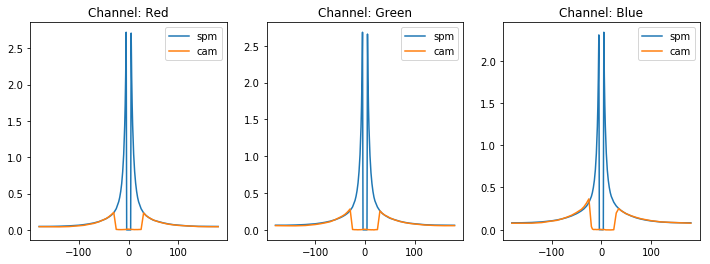

In [61]:
camera_id = 'cam_112bL'
time_index = -2
date = '2017-05-19'

spm_dfs = [df[date][df[date]["Wavelength(um)"]==wl] for wl in SUNPHOTOMETER_WAVELENGTHS]
camera_df = camera_client.query(camera_id, date)[0]

_, axes = plt.subplots(ncols=3, figsize=(12, 4))

for ch_index, (ax, color) in enumerate(zip(axes.flatten(), ("Red", "Green", "Blue"))):
    #
    # Capture image at specific channel.
    #
    angles, values, samples, img, closest_time, img_data = sampleData(
        camera_client=camera_client,
        spm_dfs=spm_dfs,
        QEs=QEs,
        ch_index=ch_index,
        time_index=time_index,
        camera_df=camera_df,
        camera_id=camera_id
    )
    
    ax.plot(angles, values, label="spm")
    ax.plot(angles, models[ch_index].predict(samples[:, ch_index].reshape(-1, 1)), label="cam")
    ax.set_title("Channel: {}".format(color))
    ax.legend()

### Apply the Models to other Times

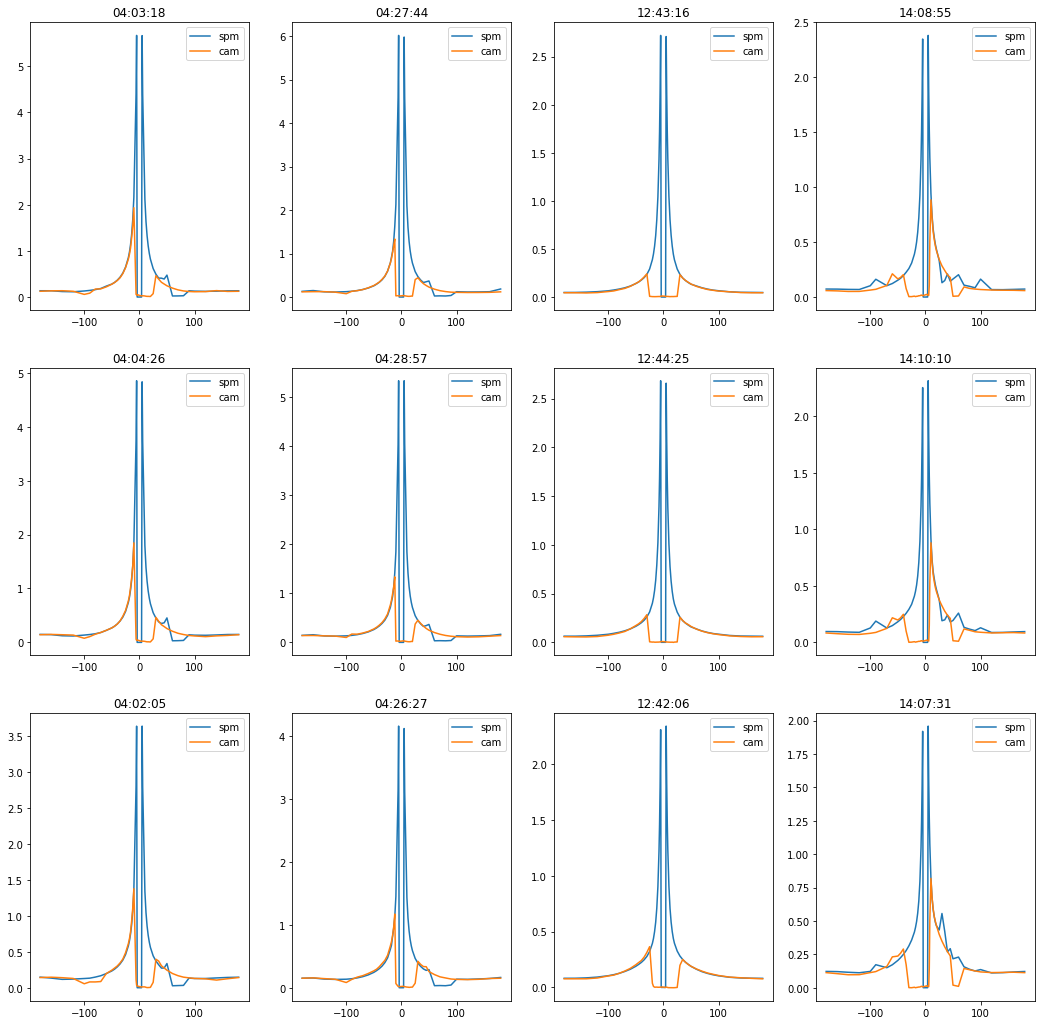

In [63]:
camera_id = 'cam_112bL'
date = '2017-05-19'

spm_dfs = [df[date][df[date]["Wavelength(um)"]==wl] for wl in SUNPHOTOMETER_WAVELENGTHS]
camera_df = camera_client.query(camera_id, date)[0]

time_samples = spm_dfs[0].shape[0]
f, axes = plt.subplots(nrows=3, ncols=time_samples, figsize=(18, 18))

for time_index in tqdm(range(time_samples), leave=False):
    for ch_index, wl in enumerate(("Red", "Green", "Blue")):
        
        #
        # Capture image at specific channel.
        #
        angles, values, samples, img, closest_time, img_data = sampleData(
            camera_client=camera_client,
            spm_dfs=spm_dfs,
            QEs=QEs,
            ch_index=ch_index,
            time_index=time_index,
            camera_df=camera_df,
            camera_id=camera_id
        )

        t = spm_dfs[ch_index].index[time_index]
        ax = axes[ch_index, time_index]
        ax.plot(angles, values, label="spm")
        ax.plot(angles, models[ch_index].predict(samples[:, ch_index].reshape((-1, 1))), label="cam")
        ax.set_title("{}".format(t.time()))
        ax.legend()

#### Save the Models

In [192]:
ratios = [model.steps[1][1].estimator_.coef_[1] for model in models]
with open("radiometric_{}.pkl".format(img_data.camera_info["serial_num"]), 'wb') as f:
    cPickle.dump(dict(ratios=ratios), f)

## Check on another camera

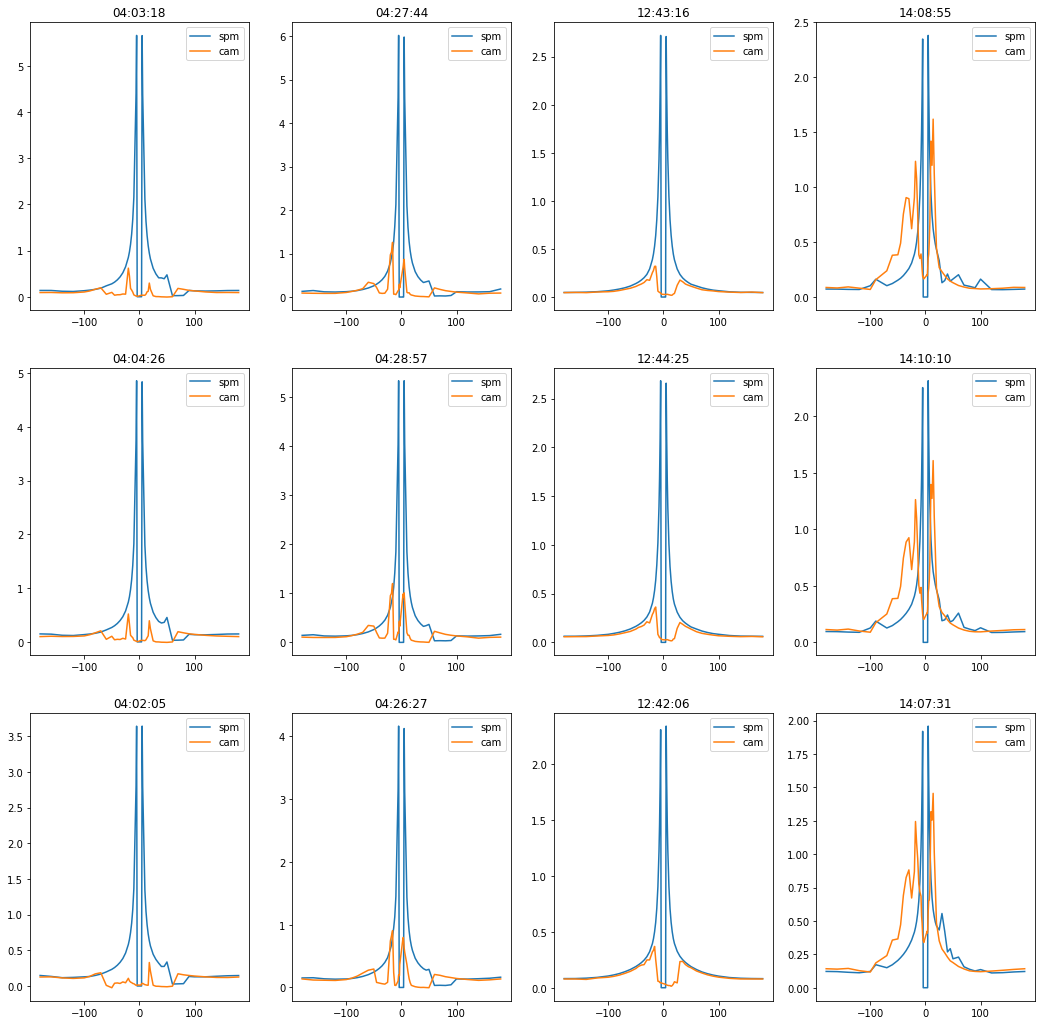

In [65]:
camera_id = 'cam_115bL'
date = '2017-05-19'
spm_dfs = [df[date][df[date]["Wavelength(um)"]==wl] for wl in SUNPHOTOMETER_WAVELENGTHS]

time_samples = spm_dfs[0].shape[0]
camera_df = camera_client.query(camera_id, date)[0]

f, axes = plt.subplots(nrows=3, ncols=time_samples, figsize=(18, 18))

for time_index in tqdm(range(time_samples), leave=False):
    for ch_index, wl in enumerate(("Red", "Green", "Blue")):
        #
        # Capture image at specific channel.
        #
        angles, values, samples, img, closest_time, img_data = sampleData(
            camera_client=camera_client,
            spm_dfs=spm_dfs,
            QEs=QEs,
            ch_index=ch_index,
            time_index=time_index,
            camera_df=camera_df,
            camera_id=camera_id
        )
        
        t = spm_dfs[ch_index].index[time_index]
        ax = axes[ch_index, time_index]
        ax.plot(angles, values, label="spm")
        ax.plot(angles, models[ch_index].predict(samples[:, ch_index].reshape((-1, 1))), label="cam")
        ax.set_title("{}".format(t.time()))
        ax.legend()

## Check on another day

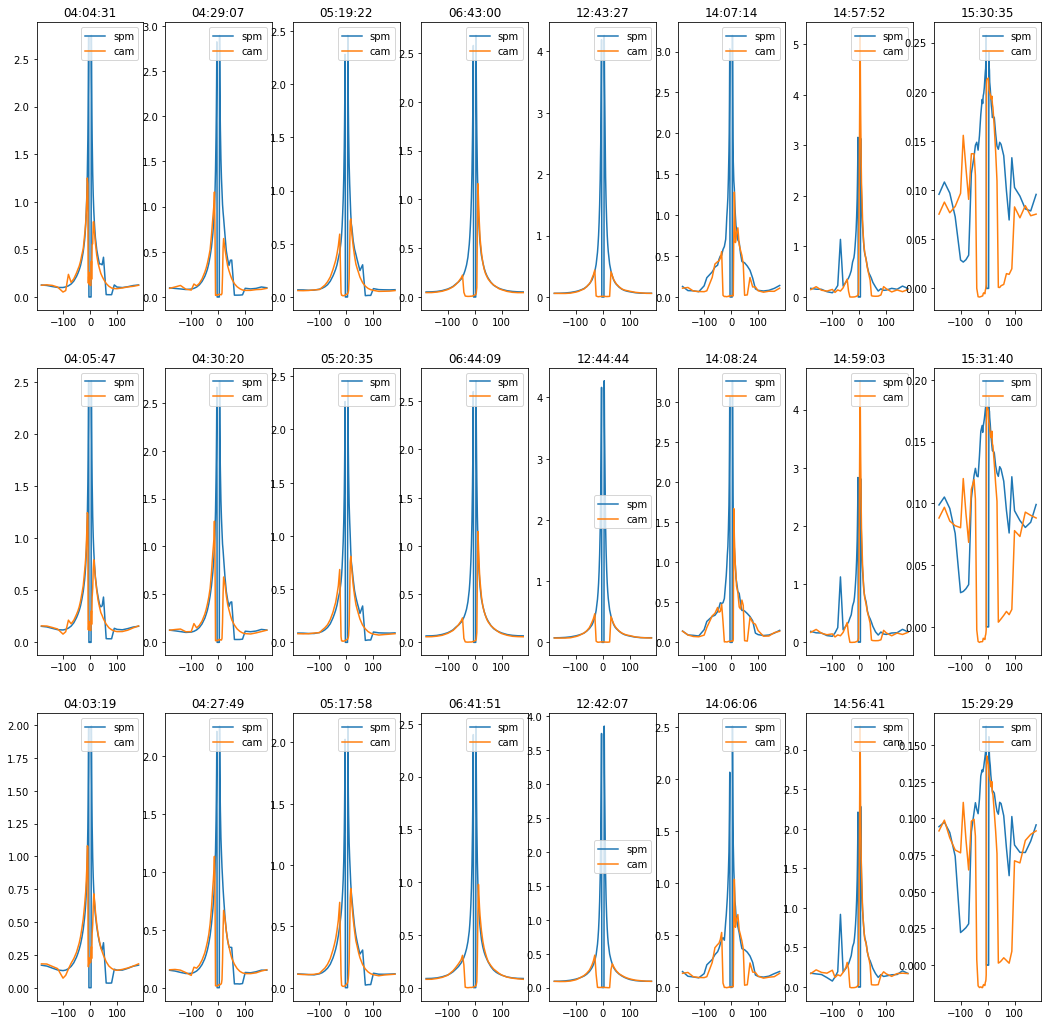

In [64]:
camera_id = 'cam_112bL'
date = '2017-05-17'

spm_dfs = [df[date][df[date]["Wavelength(um)"]==wl] for wl in SUNPHOTOMETER_WAVELENGTHS]
time_samples = spm_dfs[0].shape[0]

camera_df = camera_client.query(camera_id, date)[0]

f, axes = plt.subplots(nrows=3, ncols=time_samples, figsize=(18, 18))

for time_index in tqdm(range(time_samples), leave=False):
    for ch_index, wl in enumerate(("Red", "Green", "Blue")):
        angles, values, samples, img, closest_time, img_data = sampleData(
            camera_client=camera_client,
            spm_dfs=spm_dfs,
            QEs=QEs,
            ch_index=ch_index,
            time_index=time_index,
            camera_df=camera_df,
            camera_id=camera_id
        )
        
        t = spm_dfs[ch_index].index[time_index]
        ax = axes[ch_index, time_index]
        ax.plot(angles, values, label="spm")
        ax.plot(angles, models[ch_index].predict(samples[:, ch_index].reshape((-1, 1))), label="cam")
        ax.set_title("{}".format(t.time()))
        ax.legend()

# Old Stuff

In [201]:
import pickle
with open("/VISL2_net/amitibo/experiment_2017_02-03/cam_109b/radiometric.pkl", "rb") as f:
    ratios = pickle.load(f)

In [202]:
ratios

{'ratios': [0.0025946043956850471,
  0.0023146700362069194,
  0.0034279864880272441]}

## Check on another day

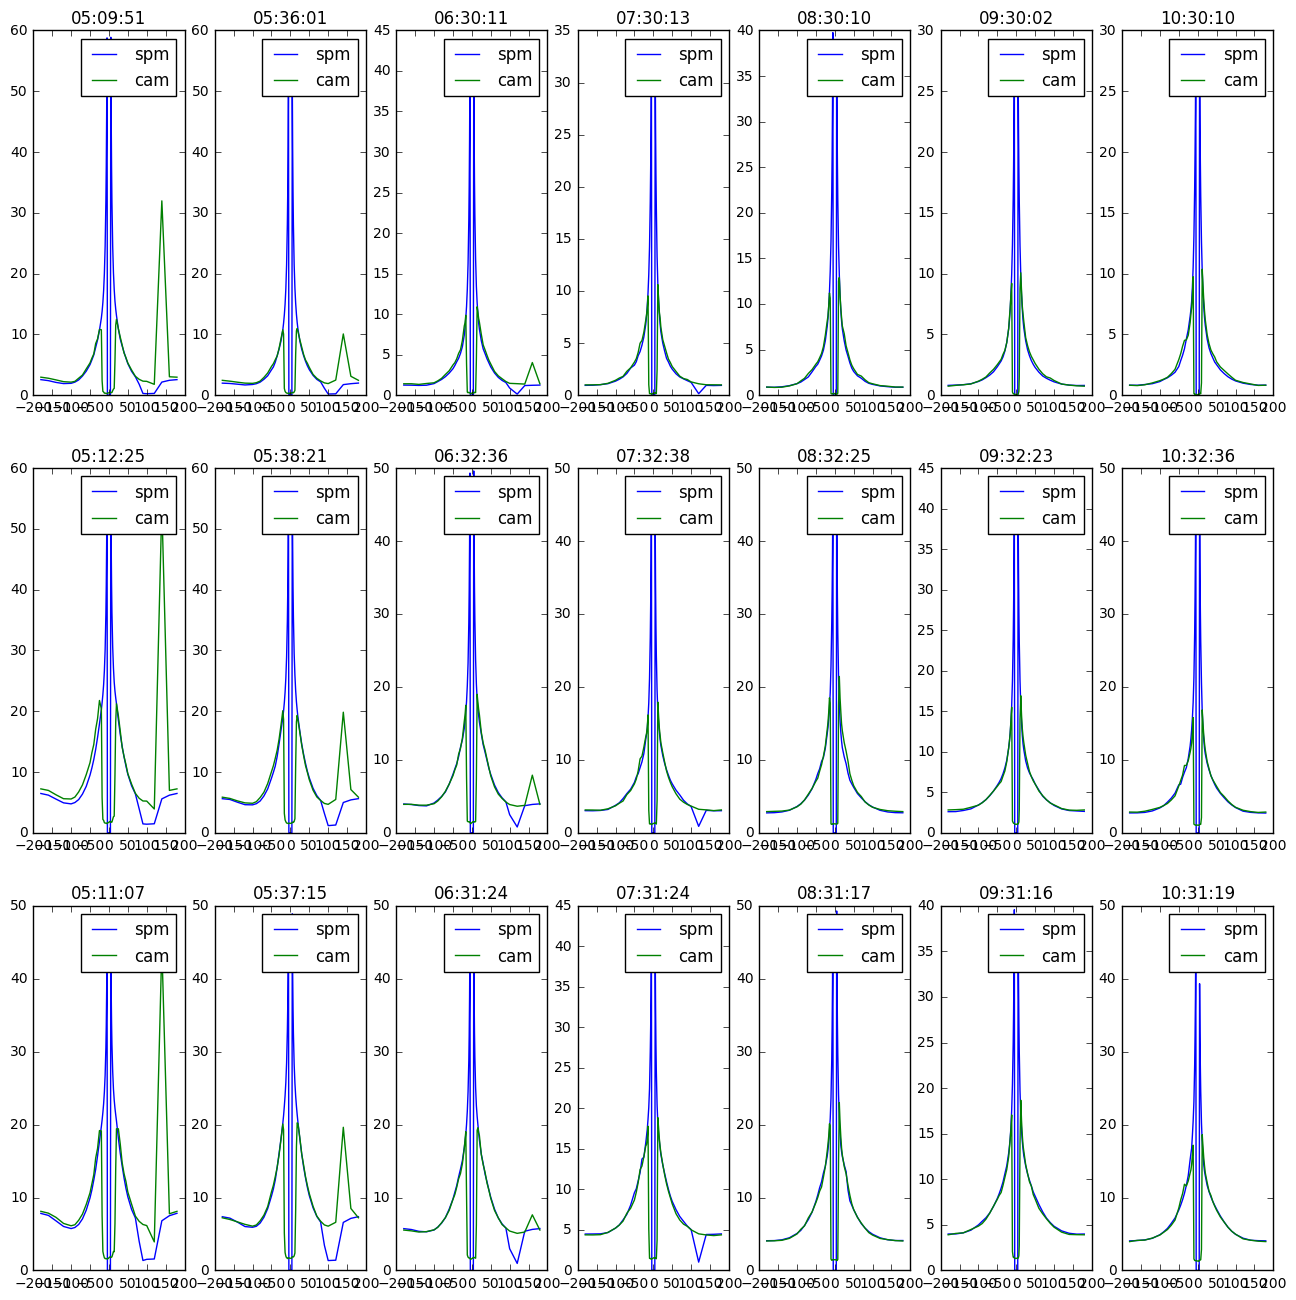

In [11]:
date = '2016-10-20'
spm_df = [df[date][df[date]["Wavelength(um)"]==wl] for wl in (0.6744, 0.5000, 0.4405)]

qdf_102 = cams.query('102', date)

f, axes = plt.subplots(3, 7)
for i, wl in enumerate(("Red", "Green", "Blue")):
    for t, ax in zip(spm_df[i].index, axes[i, :].flatten()):
        angles, values, samples, img, closest_time, img_data = sampleData(spm_df[i], t, qdf_102)
        ax.plot(angles, values, label="spm")
        ax.plot(angles, models[i].predict(samples[:, i].reshape((-1, 1))), label="cam")
        ax.set_title("{}".format(t.time()))
        ax.legend()

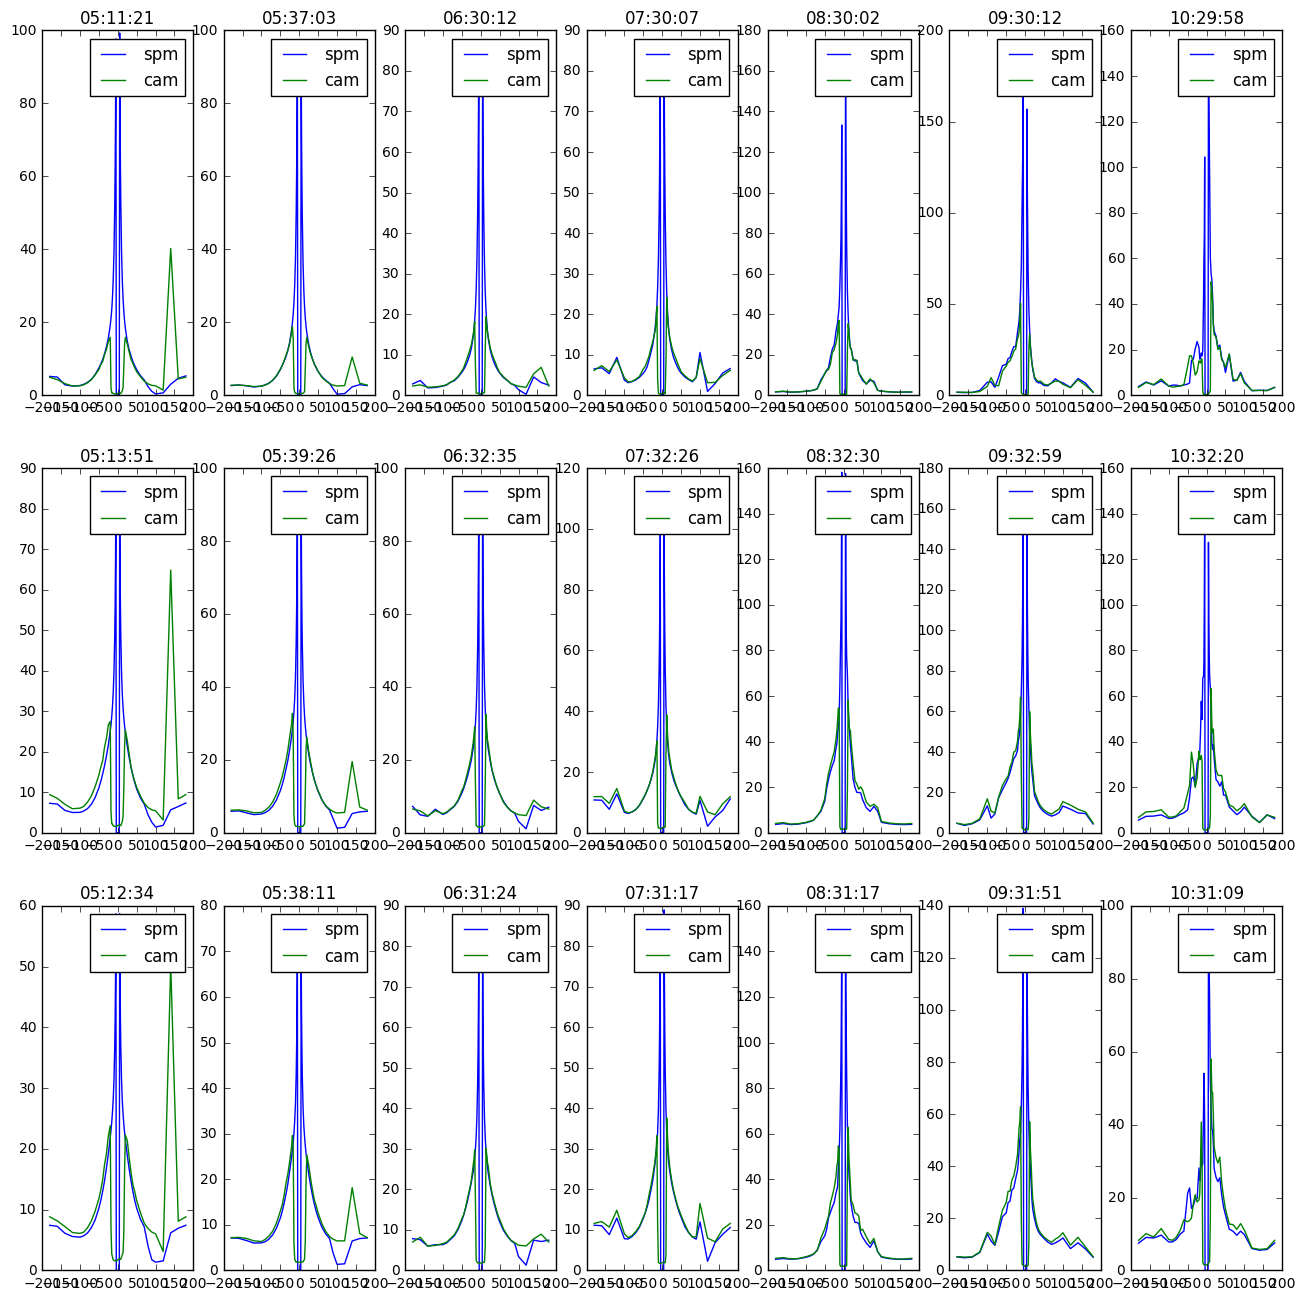

In [12]:
date = '2016-10-21'
spm_df = [df[date][df[date]["Wavelength(um)"]==wl] for wl in (0.6744, 0.5000, 0.4405)]

qdf_102 = cams.query('102', date)

f, axes = plt.subplots(3, 7)
for i, wl in enumerate(("Red", "Green", "Blue")):
    for t, ax in zip(spm_df[i].index, axes[i, :].flatten()):
        angles, values, samples, img, closest_time, img_data = sampleData(spm_df[i], t, qdf_102)
        ax.plot(angles, values, label="spm")
        ax.plot(angles, models[i].predict(samples[:, i].reshape((-1, 1))), label="cam")
        ax.set_title("{}".format(t.time()))
        ax.legend()

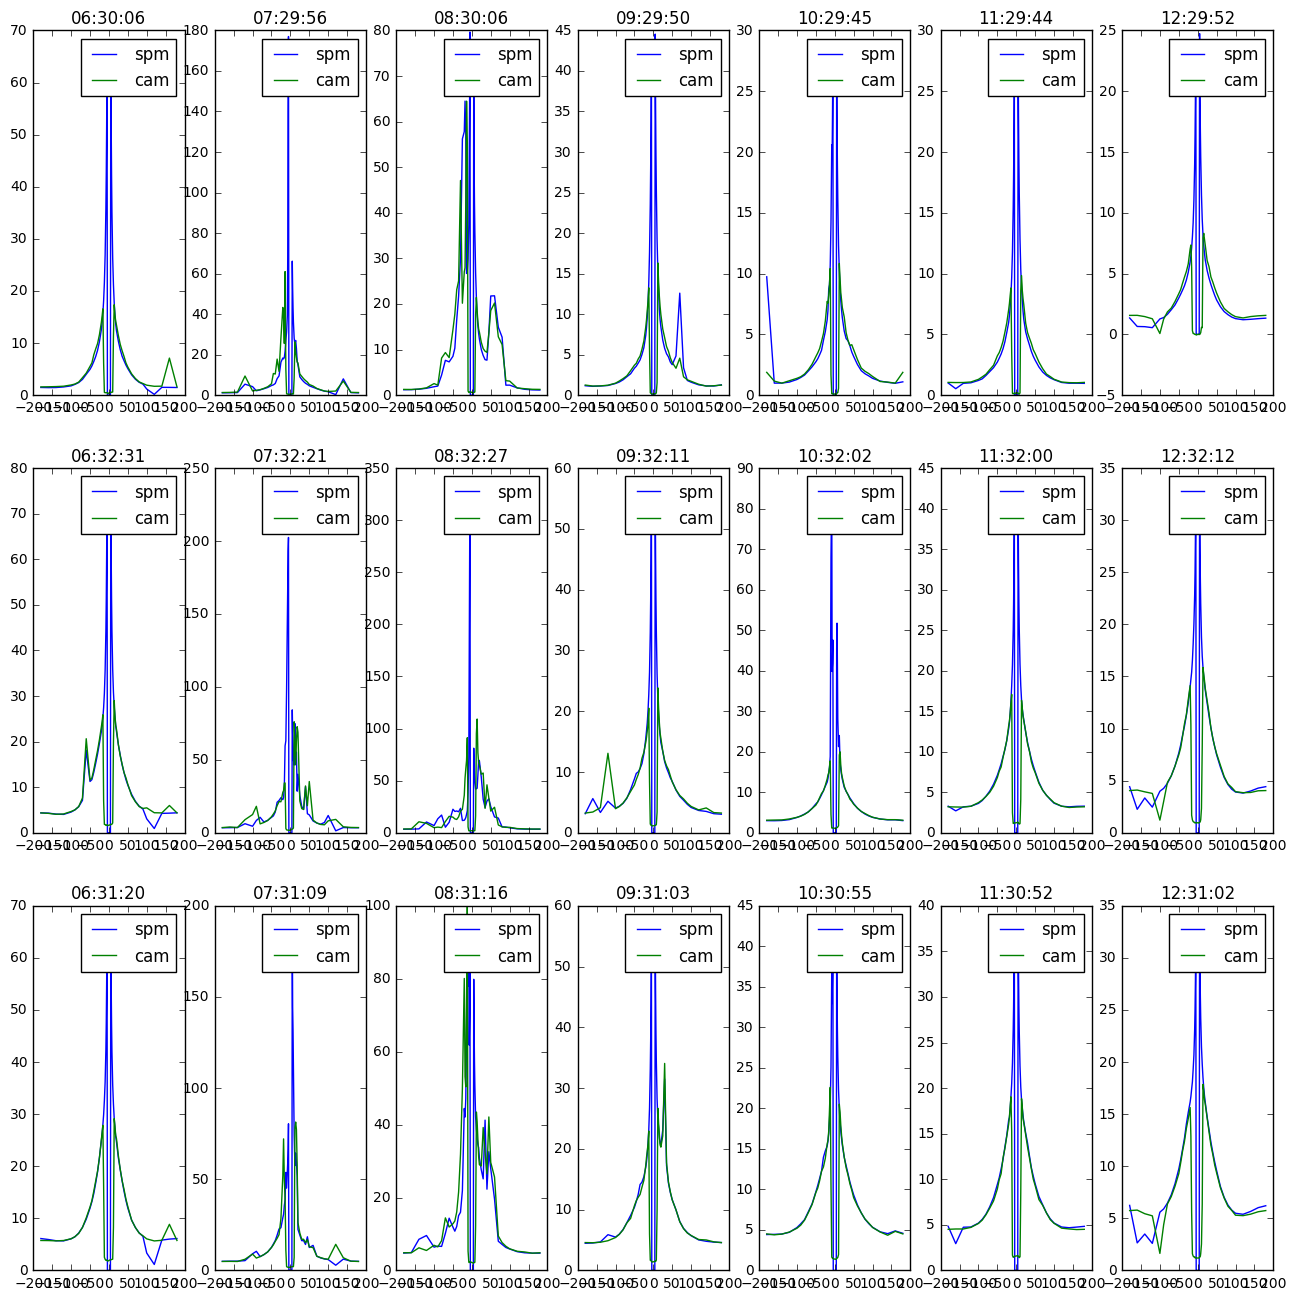

In [13]:
date = '2016-10-22'
spm_df = [df[date][df[date]["Wavelength(um)"]==wl] for wl in (0.6744, 0.5000, 0.4405)]

qdf_102 = cams.query('102', date)

f, axes = plt.subplots(3, 7)
for i, wl in enumerate(("Red", "Green", "Blue")):
    for t, ax in zip(spm_df[i].index, axes[i, :].flatten()):
        angles, values, samples, img, closest_time, img_data = sampleData(spm_df[i], t, qdf_102)
        ax.plot(angles, values, label="spm")
        ax.plot(angles, models[i].predict(samples[:, i].reshape((-1, 1))), label="cam")
        ax.set_title("{}".format(t.time()))
        ax.legend()

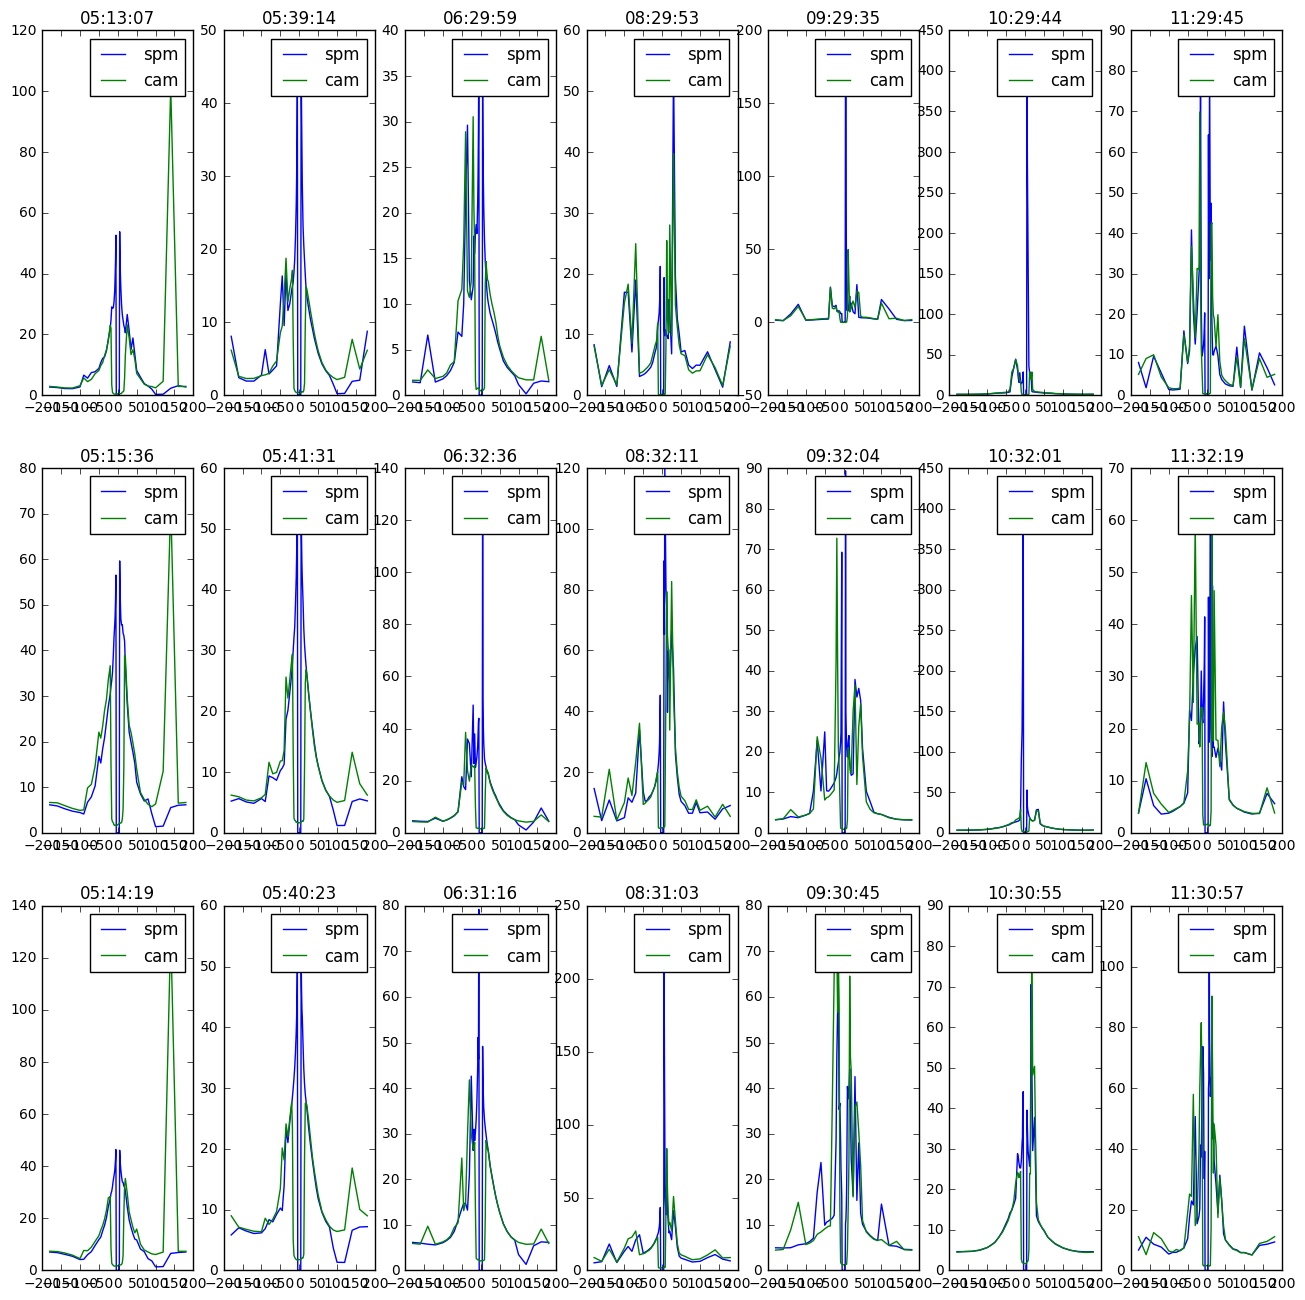

In [14]:
date = '2016-10-23'
spm_df = [df[date][df[date]["Wavelength(um)"]==wl] for wl in (0.6744, 0.5000, 0.4405)]

qdf_102 = cams.query('102', date)

f, axes = plt.subplots(3, 7)
for i, wl in enumerate(("Red", "Green", "Blue")):
    for t, ax in zip(spm_df[i].index, axes[i, :].flatten()):
        angles, values, samples, img, closest_time, img_data = sampleData(spm_df[i], t, qdf_102)
        ax.plot(angles, values, label="spm")
        ax.plot(angles, models[i].predict(samples[:, i].reshape((-1, 1))), label="cam")
        ax.set_title("{}".format(t.time()))
        ax.legend()

## Compare to all cameras

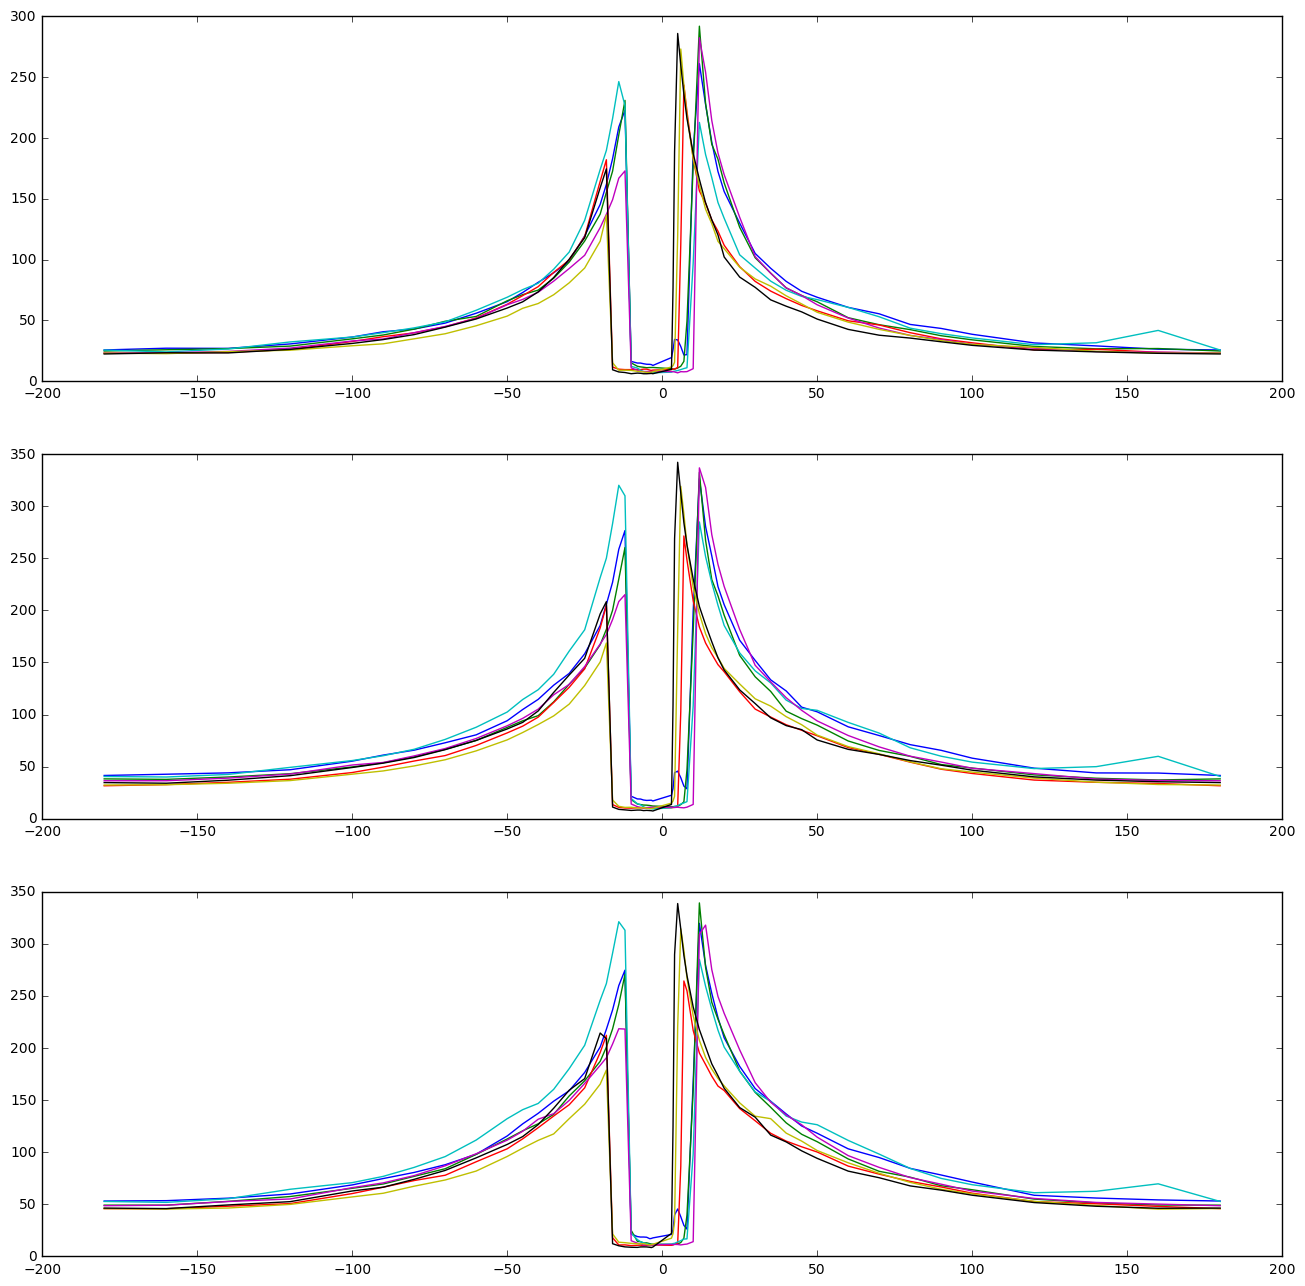

In [25]:
date = '2016-10-19'
f, axes = plt.subplots(3, 1)
t = spm_df[2].index[1]
cam_models = []
cam_samples = []
for i in range(1, 8):
    cam_id = '10{}'.format(i)
    cam_df = cams.query(cam_id, date)
    angles, _, samples, _, _, _ = sampleData(spm_df[2], t, cam_df, cam_id)
    cam_samples.append(samples)
    for j in range(3):
        axes[j].plot(angles, samples[:, j])

## Fit all cameras to Cam 102 based on the Almucantar

In [26]:
date = '2016-10-19'
t = spm_df[2].index[3]
print t
cam_id = '102'
cam_df = cams.query(cam_id, date)
angles, _, samples_102, _, _ = sampleData(spm_df[2], t, cam_df, cam_id)

def is_valid(X, y):
    return np.all((y > 20) & (y < 150))

cam_models = dict()
cam_samples = dict()
for i in (1, 3, 4, 5, 6, 7):
    cam_id = '10{}'.format(i)
    print(cam_id)
    cam_df = cams.query(cam_id, date)
    angles, _, samples, _, _ = sampleData(spm_df[2], t, cam_df, cam_id)
    models = []
    for j in range(3):
        model = make_pipeline(PolynomialFeatures(degree=1), RANSACRegressor(residual_threshold=5, max_trials=1000, is_data_valid=is_valid))
        model.fit(samples[:, j].reshape((-1, 1)), samples_102[:, j].reshape((-1, 1)))
        models.append(model)
    cam_models[cam_id] = models
    cam_samples[cam_id] = samples

2016-10-19 11:31:24
101
103
104
105
106
107


On the left is before fitting on the right after the fitting.

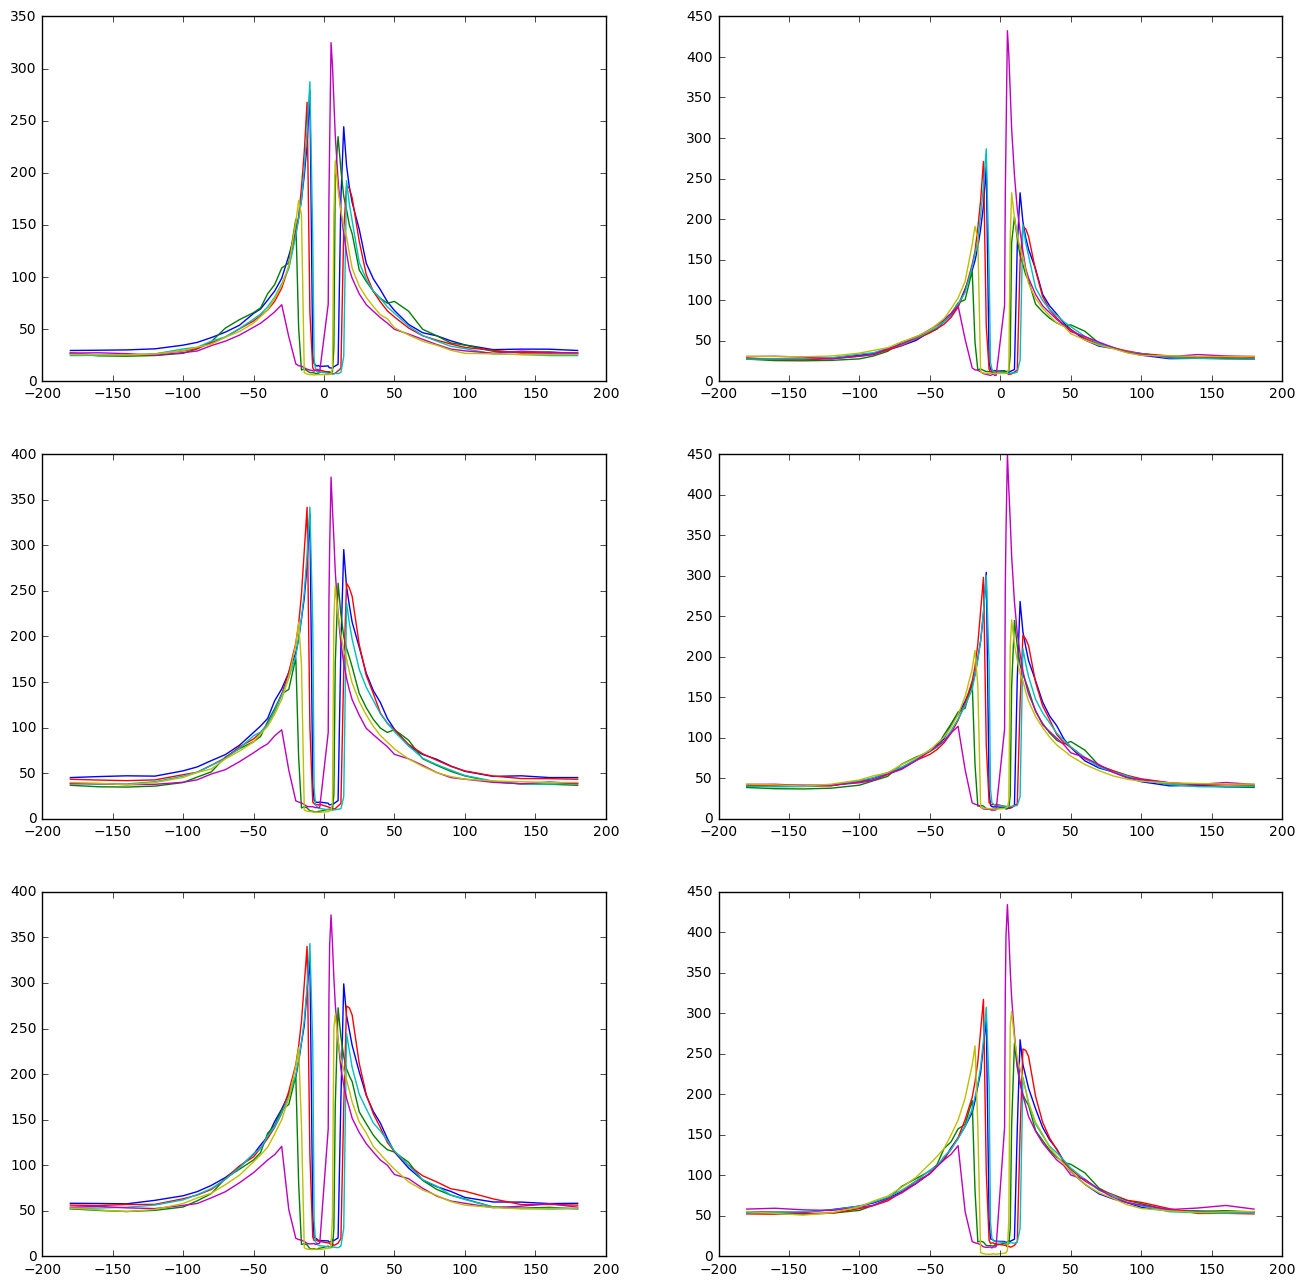

In [59]:
f, axes = plt.subplots(3, 2)
for i in (1, 3, 4, 5, 6, 7):
    cam_id = '10{}'.format(i)
    for j in range(3):
        models = cam_models[cam_id]
        samples = cam_samples[cam_id]
        tmp = models[j].predict(samples[:, j].reshape(-1, 1))
        axes[j, 0].plot(angles, cam_samples[cam_id][:, j])
        axes[j, 1].plot(angles, tmp)

## Ratio between each camera and camera 102 according to Almucantar

In [77]:
cam_ids, R, G, B = [], [], [], []
for i in (1, 3, 4, 5, 6, 7):
    cam_id = '10{}'.format(i)
    cam_ids.append(cam_id)
    R.append(cam_models[cam_id][0].steps[1][1].estimator_.coef_[0][1])
    G.append(cam_models[cam_id][1].steps[1][1].estimator_.coef_[0][1])
    B.append(cam_models[cam_id][2].steps[1][1].estimator_.coef_[0][1])
    
pd.DataFrame({'R':R, 'G': G, 'B': B}, index=cam_ids, columns=('R', 'G', 'B'))

,R,G,B
101,0.957016,0.914628,0.883177
103,0.843381,0.929400,0.943916
104,1.008111,0.859776,0.932540
105,0.987771,0.857663,0.872829
106,1.349310,1.211447,1.172096
107,1.087380,0.938838,1.162573


## Elbit results

Here we load Elbit calibration data that was calculated using the 'scripts_calibrate/analyze_elbit_measurements.py' script. This data is used to measure the radiometric response of each camera to camera 102.

In [27]:
CAM_MAP = {
    "4102820388": "cam_101",
    "4102820378": "cam_102",
    "4102820395": "cam_103",
    "4102820374": "cam_104",
    "4102820391": "cam_105",
    "4102820375": "cam_106",
    "4102820392": "cam_107",
}

with open('../../scripts_calibrate/elbit_results.pkl', 'rb') as f:
    data = cPickle.load(f)

cam_ids, R, G, B = [], [], [], []
for cam_id in sorted(CAM_MAP.values()):
    cam_ids.append(cam_id)
    cam_serial=list(CAM_MAP.keys())[list(CAM_MAP.values()).index(cam_id)]
    tmp = np.array(data["4102820378"])/np.array(data[cam_serial])
    R.append(tmp[0])
    G.append(tmp[1])
    B.append(tmp[2])

pd.DataFrame({'R':R, 'G': G, 'B': B}, index=cam_ids, columns=('R', 'G', 'B'))

,R,G,B
cam_101,1.051797,0.965710,1.005324
cam_102,1.000000,1.000000,1.000000
cam_103,0.966785,0.992743,0.979552
cam_104,0.961387,0.908698,0.941777
cam_105,1.108716,1.005257,1.056330
cam_106,1.115198,1.062346,1.079133
cam_107,1.198078,1.103405,1.130218


## Calculate Radiometric calibration for cameras

We use the sunphotometer to calibrate the camera 102. Then we use the elbit ratios to calibrate the rest of the cameras to 102 and the sunphotometer.

In [38]:
#
# Load the Elbit camera ratios.
#
with open("cam_102_sunphotometer_ratios.pkl", 'rb') as f:
    ratios = cPickle.load(f)

#
# Save calibration to home folders of the cameras.
#
base_path = r'D:\data\experiment_sukot_2016'
for cam_id in sorted(CAM_MAP.values()):
    cam_serial=list(CAM_MAP.keys())[list(CAM_MAP.values()).index(cam_id)]
    tmp = np.array(data["4102820378"])/np.array(data[cam_serial])
    with open(os.path.join(base_path, cam_id, '.radiometric.pkl'), 'wb') as f:
        cPickle.dump(dict(ratios=(tmp[0]*ratios[0], tmp[1]*ratios[1], tmp[2]*ratios[2])), f)

In [ ]:
cv2.WINDO